In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import export_graphviz
import imblearn as imb
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss
from joblib import Memory
import shap


In [26]:
### Seed
seed = 200
near_miss_strat = 3
knn_ = 3

In [3]:
### Reading .pkl file
num_chr = '1'
pd_df = pd.read_pickle(f"/mnt/wd/nsap/imp2/chr{num_chr}.pkl")
print('Original DF: ', pd_df, sep='\n')

## Saving 1st two columns
classes = pd_df['PHENOTYPE']
pd_df_out = pd_df[['IID','PHENOTYPE']].copy()
pd_df.drop(['IID','PHENOTYPE'], axis=1, inplace=True)

### One-Hot encode
print('Performing one-hot encoding...')
enc = OneHotEncoder(sparse=False, handle_unknown='error')
enc.fit(pd_df)
pd_df_enc = enc.transform(pd_df)
pd_df_columns = enc.get_feature_names_out()
pd_df_enc = pd.DataFrame(pd_df_enc, columns=pd_df_columns)
print('Encoded...')

pd_df_enc = pd.DataFrame(pd_df_enc, columns=pd_df_columns)
# print(pd_df_enc)

Original DF: 
             IID  PHENOTYPE  rs3094315_G  rs3131972_A  rs3131969_A  \
0      100000013          2            1            1            1   
1      100000016          2            1            1            1   
2      100000023          2            1            1            0   
3      100000140          2            0            0            0   
4      100000147          2            1            1            1   
...          ...        ...          ...          ...          ...   
5575  2909813962          2            0            0            0   
5576  2909884763          2            0            0            0   
5577  2909921261          2            1            1            0   
5578  2909922663          2            0            0            0   
5579  2909962868          2            0            0            0   

      rs1048488_G  rs12562034_A  rs12124819_G  rs2980300_A  rs11240777_A  ...  \
0               1             0             0            1      

In [5]:
### Object to over-sample the minority class by picking samples at random with replacement. 
random_over = imb.over_sampling.RandomOverSampler(sampling_strategy=0.3
                                                 ,random_state=seed)

In [27]:
### NearMiss-1 selects the positive samples for which the average distance to the N
### closest samples of the negative class is the smallest.
undersample = NearMiss(sampling_strategy=0.5,
                       version=near_miss_strat, 
                       n_neighbors=knn_)
### near_miss_strat

In [14]:
### Split training set from general_set
print('Splitting dataset...')
training_set, test_set, training_classes, test_classes = train_test_split(pd_df_enc
                                                        ,classes
                                                        ,test_size=0.2
                                                        ,random_state = seed)
print(f"Original class counts in training: {Counter(training_classes)}")
print(f"Original class counts in test: {Counter(test_classes)}")

Splitting dataset...
Original class counts in training: Counter({2: 3938, 1: 526})
Original class counts in test: Counter({2: 990, 1: 126})


In [28]:
### Create 2 lists with 'IID' which are either selected via NearMiss or not
print('Performing NearMiss undersampling...')
# set_res, classes_res = undersample.fit_resample(training_set, training_classes) 
set_res, classes_res = undersample.fit_resample(pd_df_enc, classes) 
inx = undersample.sample_indices_
print(inx)
print(len(inx))
print(len(set_res))



Performing NearMiss undersampling...


The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.


[4212 4213 4214 ... 4977 4892 4200]
1898
1898


In [29]:
positive_list = pd_df_out['IID'].iloc[inx]
print(len(positive_list))

1898


In [30]:
path = '/mnt/wd/nsap/Classifiers/RandomForest_dbgap/'
positive_list = pd_df_out['IID'].iloc[inx]
print('Positive selected indexes: ', positive_list)
positive_list.to_csv(f"{path}positiveSelected_NearMiss{near_miss_strat}_{knn_}.csv", 
                     sep='\n', index=False)
negative_list = pd_df_out['IID'].drop(index=inx)
print('Negative selected indexes: ', negative_list)
negative_list.to_csv(f"{path}negativeSelected_NearMiss{near_miss_strat}_{knn_}.csv", 
                     sep='\n', index=False)

Positive selected indexes:  4212    2000001500
4213    2000001501
4214    2000001503
4215    2000001504
4216    2000001505
           ...    
3495    2000000083
4780    2300000351
4977    2300000860
4892    2300000614
4200    2000001460
Name: IID, Length: 1898, dtype: int64
Negative selected indexes:  1        100000016
3        100000140
4        100000147
5        100000158
6        100000222
           ...    
5574    2909779221
5575    2909813962
5577    2909921261
5578    2909922663
5579    2909962868
Name: IID, Length: 3682, dtype: int64


In [32]:
### List for either of 1 PHENOTYPEs
control_list = pd_df_out[pd_df_out.PHENOTYPE != 2]['IID']
print(control_list)

4212    2000001500
4213    2000001501
4214    2000001503
4215    2000001504
4216    2000001505
           ...    
5237    2300005910
5238    2300005911
5239    2300005935
5240    2300005961
5241    2300006051
Name: IID, Length: 652, dtype: int64


In [ ]:
### Oversampling technique SMOTEN (Synthetic Minority Over-sampling Technique for Nominal)
print(f"Original class counts: {Counter(classes)}")
smoten_over = imb.over_sampling.SMOTEN(sampling_strategy=1
                                       ,random_state=seed
                                       ,n_jobs=-1)

In [6]:
### RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100
                            ,max_features=None
                            ,criterion='gini'
                            ,bootstrap=True
                            ,oob_score=False
                            ,random_state=seed
                            ,class_weight='balanced_subsample'
                            ,n_jobs=-1)

In [24]:
### Define imblearn.pipeline
steps = [('under', undersample), ('model', clf)]
mem = Memory(location='./cachedir')
pipeline = Pipeline(steps=steps, memory=mem)
#  ('under', undersample),('over', random_over), 

In [17]:
### Repeated stratified k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)

In [ ]:
### NearMiss-1 selects the positive samples for which the average distance to the N
### closest samples of the negative class is the smallest.
undersample = NearMiss(sampling_strategy=0.2,
                       version=near_miss_strat, n_neighbors=3)
### Oversampling technique SMOTEN (Synthetic Minority Over-sampling Technique for Nominal)
smoten_over = imb.over_sampling.SMOTEN(sampling_strategy=0.5
                                       ,random_state=seed
                                       ,n_jobs=-1)
print(f"Original class counts: {Counter(training_classes)}")
print('Performing NearMiss undersampling...')
set_res, classes_res = undersample.fit_resample(training_set, training_classes) 
print(f"Original class counts: {Counter(classes_res)}")
print('Performing SMOTEN oversampling...')
set_res, classes_res = smoten_over.fit_resample(set_res, classes_res)
print(f"Original class counts: {Counter(classes_res)}")

In [26]:
### Scoring
cv_scores = cross_validate(pipeline
                          ,training_set
                          ,training_classes
                          ,scoring=('accuracy'
                                   ,'precision'
                                   ,'precision_macro'
                                   ,'precision_weighted'
                                   ,'recall'
                                   ,'recall_macro'
                                   ,'recall_weighted'
                                   ,'f1'
                                   ,'f1_macro'
                                   ,'f1_weighted')
                          ,cv=5
                          ,return_estimator=True
                          ,n_jobs=15)

In [12]:
print(cv_scores)

{'fit_time': array([3127.1173315 , 3138.40546107, 3500.92359829, 3548.95322561,
       3559.84075379]), 'score_time': array([13.19507718,  7.75673676,  5.0032239 ,  2.84196115,  2.48560429]), 'estimator': [Pipeline(memory=Memory(location=./cachedir/joblib),
         steps=[('over',
                 RandomOverSampler(random_state=100, sampling_strategy=0.3)),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_features=None, n_jobs=-1,
                                        random_state=100))]), Pipeline(memory=Memory(location=./cachedir/joblib),
         steps=[('over',
                 RandomOverSampler(random_state=100, sampling_strategy=0.3)),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_features=None, n_jobs=-1,
                                        random_state=100))]), Pipeline(memory=Me

In [19]:
test_pred_classes = cv_scores['estimator'][1]['model'].predict(test_set)
p_score = precision_score(test_classes, test_pred_classes, average=None)
print(f"Precision score is: {p_score}")
r_score = recall_score(test_classes, test_pred_classes, average=None)
print(f"Recall score is: {r_score}")
f_score = f1_score(test_classes, test_pred_classes, average=None)
print(f"F1 score is: {f_score}")

Precision score is: [0.         0.88789238]
Recall score is: [0.         0.99899092]
F1 score is: [0.         0.94017094]


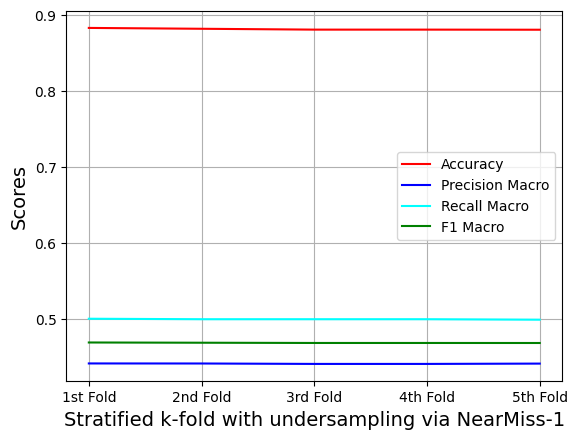

In [27]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.plot(cv_scores['test_accuracy'], color='red', label='Accuracy')
plt.plot(cv_scores['test_precision_macro'], color='blue', label='Precision Macro')
plt.plot(cv_scores['test_recall_macro'], color='cyan', label='Recall Macro')
plt.plot(cv_scores['test_f1_macro'], color='green', label='F1 Macro')

plt.xticks(X_axis, labels)
plt.xlabel(f"Stratified k-fold with undersampling via NearMiss-{near_miss_strat}", fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import shap
explainer = shap.TreeExplainer(cv_scores['estimator'][1]['model'])
shap_values = explainer.shap_values(test_set)
#shap_values of 1 for positive label
shap.summary_plot(shap_values[1], test_set)

In [ ]:
test_pred = cv_scores['estimator'][1].predict(test_set)
print(Counter(test_classes))
print(Counter(test_pred))

In [ ]:
## Accuracy
print('Accuracy of the model is: ', cv_scores['test_accuracy'])

## Precision
print("Macro precision score of the model: ", cv_scores['test_precision_macro'])
print("Micro precision score of the model: ", cv_scores['test_precision_micro'])
print("Weighted precision score of the model: ", cv_scores['test_precision_weighted'])

## Recall
print("Macro recall score of the model: ", cv_scores['test_recall_macro'])
print("Micro recall score of the model: ", cv_scores['test_recall_micro'])
print("Weighted recall score of the model: ", cv_scores['test_recall_weighted'])

## f1-score
print("Macro F1-score of the model: ", cv_scores['test_f1_macro'])
print("Micro F1-score of the model: ", cv_scores['test_f1_micro'])
print("Weighted F1-score of the model: ", cv_scores['test_f1_weighted'])

In [ ]:
## Precision
print("Macro precision score of the model: ", cv_scores['test_precision_macro'])
print("Micro precision score of the model: ", cv_scores['test_precision_micro'])
print("Weighted precision score of the model: ", cv_scores['test_precision_weighted'])



In [ ]:
## Recall
print("Macro recall score of the model: ", cv_scores['test_recall_macro'])
print("Micro recall score of the model: ", cv_scores['test_recall_micro'])
print("Weighted recall score of the model: ", cv_scores['test_recall_weighted'])



In [ ]:
## f1-score
print("Macro F1-score of the model: ", cv_scores['test_f1_macro'])
print("Micro F1-score of the model: ", cv_scores['test_f1_micro'])
print("Weighted F1-score of the model: ", cv_scores['test_f1_weighted'])

In [ ]:
clf = clf.fit(training_set, training_classes)
test_pred_classes = clf.predict(test_set)
print(Counter(test_pred_classes))

In [ ]:
### Split training set from general_set
print('Splitting dataset...')
training_set, test_set, training_classes, test_classes = train_test_split(pd_df_enc
                                                        ,classes
                                                        ,test_size=0.333
                                                        ,random_state = seed)

In [ ]:
test_pred = cv_scores['estimator'][0].predict(test_set)


In [ ]:
### Scoring
cv_scores = cross_validate(pipeline
                          ,pd_df_enc
                          ,classes
                          ,scoring=('accuracy'
                                   ,'precision_macro'
                                   ,'precision_micro'
                                   ,'precision_weighted'
                                   ,'recall_macro'
                                   ,'recall_micro'
                                   ,'recall_weighted'
                                   ,'f1_macro'
                                   ,'f1_micro'
                                   ,'f1_weighted')
                          ,cv=cv
                          ,return_estimator=True
                          ,n_jobs=12)

In [ ]:
print(cv_scores['estimator'][0])

In [ ]:
test_pred = cv_scores['estimator'][1].predict(pd_df_enc)
print(Counter(test_pred))

In [ ]:
print(Counter(classes))

In [ ]:
test_pred = cv_scores['estimator'][2].predict(pd_df_enc)
print(Counter(test_pred))

In [ ]:
test_pred = cv_scores['estimator'][3].predict(pd_df_enc)
print(Counter(test_pred))

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.plot(cv_scores['test_accuracy'], color='red', label='Accuracy')
plt.plot(cv_scores['test_precision_macro'], color='blue', label='Precision Macro')
plt.plot(cv_scores['test_recall_macro'], color='cyan', label='Recall Macro')
plt.plot(cv_scores['test_f1_macro'], color='green', label='F1 Macro')

plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-1', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_precision_macro'], color='red', label='Precision Macro')
# plt.plot(cv_scores['test_precision_weighted'], color='blue', label='Precision Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-1', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_recall_macro'], color='red', label='Recall Macro')
# plt.plot(cv_scores['test_recall_micro'], color='blue', label='Recall Micro')
# plt.plot(cv_scores['test_recall_weighted'], color='cyan', label='Recall Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-1', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_f1_macro'], color='red', label='F1 Macro')
plt.plot(cv_scores['test_f1_micro'], color='blue', label='F1 Micro')
plt.plot(cv_scores['test_f1_weighted'], color='cyan', label='F1 Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-1', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_pred = cv_scores['estimator'][3].predict(pd_df_enc)
print(Counter(test_pred))

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.plot(cv_scores['test_accuracy'], color='red', label='Accuracy')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-2', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_precision_macro'], color='red', label='Precision Macro')
plt.plot(cv_scores['test_precision_micro'], color='blue', label='Precision Micro')
plt.plot(cv_scores['test_precision_weighted'], color='cyan', label='Precision Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-2', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_recall_macro'], color='red', label='Recall Macro')
plt.plot(cv_scores['test_recall_micro'], color='blue', label='Recall Micro')
plt.plot(cv_scores['test_recall_weighted'], color='cyan', label='Recall Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-2', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_f1_macro'], color='red', label='F1 Macro')
plt.plot(cv_scores['test_f1_micro'], color='blue', label='F1 Micro')
plt.plot(cv_scores['test_f1_weighted'], color='cyan', label='F1 Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-2', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.plot(cv_scores['test_accuracy'], color='red', label='Accuracy')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-3', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_precision_macro'], color='red', label='Precision Macro')
plt.plot(cv_scores['test_precision_micro'], color='blue', label='Precision Micro')
plt.plot(cv_scores['test_precision_weighted'], color='cyan', label='Precision Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-3', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_recall_macro'], color='red', label='Recall Macro')
plt.plot(cv_scores['test_recall_micro'], color='blue', label='Recall Micro')
plt.plot(cv_scores['test_recall_weighted'], color='cyan', label='Recall Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-3', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
plt.plot(cv_scores['test_f1_macro'], color='red', label='F1 Macro')
plt.plot(cv_scores['test_f1_micro'], color='blue', label='F1 Micro')
plt.plot(cv_scores['test_f1_weighted'], color='cyan', label='F1 Weighted')
plt.xticks(X_axis, labels)
plt.xlabel('Stratified k-fold with undersampling via NearMiss-3', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Accuracy
print('Accuracy of the model is: ', cv_scores['test_accuracy'], '\n')

## Precision
print("Macro precision score of the model: ", cv_scores['test_precision_macro'])
print("Micro precision score of the model: ", cv_scores['test_precision_micro'])
print("Weighted precision score of the model: ", cv_scores['test_precision_weighted'], '\n')

## Recall
print("Macro recall score of the model: ", cv_scores['test_recall_macro'])
print("Micro recall score of the model: ", cv_scores['test_recall_micro'])
print("Weighted recall score of the model: ", cv_scores['test_recall_weighted'], '\n')

## f1-score
print("Macro F1-score of the model: ", cv_scores['test_f1_macro'])
print("Micro F1-score of the model: ", cv_scores['test_f1_micro'])
print("Weighted F1-score of the model: ", cv_scores['test_f1_weighted'])

In [ ]:
### Oversampling technique SMOTEN (Synthetic Minority Over-sampling Technique for Nominal)
print(f"Original class counts: {Counter(classes)}")
smoten_over = imb.over_sampling.SMOTEN(sampling_strategy=0.5
                                       ,random_state=seed
                                       ,n_jobs=20)
# pd_df_smoten, classes_smoten = smoten_over.fit_resample(pd_df_enc, classes)
# print(f"Class counts after resampling {Counter(pd_df_smoten)}")
# print('pd_df_res: ', pd_df_smoten, sep='\n')

In [ ]:
### Define imblearn.pipeline
steps_over = [('over', smoten_over), ('model', clf)]
mem = Memory(location='./cachedir')
pipeline_over = Pipeline(steps=steps_over, memory=mem)


In [ ]:
### Split training set from general_set
print('Splitting dataset...')
training_set, test_set, training_classes, test_classes = train_test_split(pd_df_enc
                                                        ,classes
                                                        ,test_size=0.2
                                                        ,random_state = seed)
print(Counter(test_classes))

In [ ]:
clf = clf.fit(training_set, training_classes)
test_pred_classes = clf.predict(test_set)
f1_score = f1_score(test_classes, test_pred_classes, average=None)
print(f1_score)

In [ ]:
pd_df_smoten, classes_smoten = smoten_over.fit_resample(training_set, training_classes)
print(f"Class counts after resampling {Counter(pd_df_smoten)}")

In [ ]:
cv_scores_over = cross_validate(clf
                              ,pd_df_smoten
                              ,classes_smoten
                              ,scoring=('accuracy'
                                       ,'precision'
                                       ,'precision_macro'
                                       ,'precision_weighted'
                                       ,'recall'
                                       ,'recall_macro'
                                       ,'recall_weighted'
                                       ,'f1'
                                       ,'f1_macro'
                                       ,'f1_weighted')
                              ,cv=5
                              ,return_estimator=True
                              ,n_jobs=12)

In [ ]:
import shap 

In [ ]:
explainer = shap.TreeExplainer(cv_scores['estimator'][0]['model'])

In [ ]:
shap_values = explainer.shap_values(test_pred)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
### Scoring feature importances
feature_names = test_set.columns
print(feature_names)
